## Comparison of our Implementation with QuaPy

Evaluation will be conducted on LeQua dataset, as provided by the authors of the QuaPy package.

To be able to run this notebook, you need to install the ```quapy``` environment as provided in a yml-file in the ```envs``` folder. Further, to generate the plots, it is required to first generate the corresponding results from our ```QFY``` implementation.
This can be done from the command line, with the ```quant``` environment required to be active.
For the binary setting, one can run
```
python -m run_lequa -e 1 --modes binary -a CC AC PCC PAC EM HDy TS50 TSX TSMax MS DyS
```

To obtain the multiclass results, one can run 
```
python -m run_lequa -e 1 --modes multiclass -a CC GAC PCC GPAC EM HDy TS50 TSX TSMax MS DyS
```

In [1]:
import quapy as qp
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt

from QFY.metrics import calc_eps, AE, RAE, NKLD
from helpers import melt_plotting_dataframe
from run_lequa import save_dict_to_csv
from config import *

### Step 1: Run all Methods on LeQua Daa

We apply the same default base quantifiers as used in our experiments, as exported from ```config.py```, and try to mimick the parameter values as good as possible.

In [2]:
# here we initialize all QuaPy methods used in this comparison

quapy_dict = {
    "binary": { "CC": qp.method.aggregative.CC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "AC": qp.method.aggregative.ACC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "PCC": qp.method.aggregative.PCC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "PAC": qp.method.aggregative.PACC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "EM": qp.method.aggregative.EMQ(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "HDy": qp.method.aggregative.HDy(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "TS50": qp.method.aggregative.T50(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                "TSX": qp.method.aggregative.X(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "TSMax": qp.method.aggregative.MAX(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "MS": qp.method.aggregative.MS2(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                "DyS": qp.method.aggregative.DyS(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), n_bins=10, divergence="topsoe"), 
              },
    "multiclass": { "CC": qp.method.aggregative.CC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                    "GAC": qp.method.aggregative.ACC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                    "PCC": qp.method.aggregative.PCC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                    "GPAC": qp.method.aggregative.PACC(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10),
                    "EM": qp.method.aggregative.EMQ(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR)),
                    "HDy": qp.method.aggregative.OneVsAllAggregative(qp.method.aggregative.HDy(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR))),
                    "TS50": qp.method.aggregative.OneVsAllAggregative(qp.method.aggregative.T50(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR))),
                    "TSX": qp.method.aggregative.OneVsAllAggregative(qp.method.aggregative.X(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10)),
                    "TSMax": qp.method.aggregative.OneVsAllAggregative(qp.method.aggregative.MAX(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10)),
                    "MS": qp.method.aggregative.OneVsAllAggregative(qp.method.aggregative.MS2(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), val_split=10)),
                    "DyS": qp.method.aggregative.OneVsAllAggregative(qp.method.aggregative.DyS(classifier=clone(DEFAULT_PARAMS_LOGISTIC_REGRESSOR), n_bins=10, divergence="topsoe")), 
              },
}

In [3]:
# function to run all desired quantifiers on LeQua data - adapted from run_main_experiments function in run_lequa.py

def run_quapy(quantifiers=None, mode="binary", seed=LEQUA_MAIN_SEED):
    
    if quantifiers is None:
        quantifiers = list(quapy_dict[mode].keys())

    for str_qf in quantifiers:

        print(f"Apply {str_qf} with default parameters on {mode} lequa data")

        curr_dict = quantify_lequa_quapy(quapy_dict[mode][str_qf], mode=mode, seed=seed)
        curr_key = f"{str_qf}-QuaPy"
        save_dict_to_csv(curr_dict, curr_key, mode)

In [4]:
# function to run singlge quantifier on LeQua data - adapted from quantify_lequa function in run_lequa.py

def quantify_lequa_quapy(qf, mode, seed):
    np.random.seed(seed)

    data_dict = LEQUA_DATA_DICT[mode]
    train_data = qp.data.LabelledCollection(instances=data_dict[LEQUA_DATA_DICT_TRAIN_DATA_KEY], 
                                            labels=data_dict[LEQUA_DATA_DICT_TRAIN_LABELS_KEY])

    Y_true = data_dict[LEQUA_DATA_DICT_TEST_PREVALENCES_KEY]
    test_path = data_dict[LEQUA_DATA_DICT_TEST_PATH_KEY]

    sample_size = data_dict[LEQUA_DATA_DICT_SAMPLE_SIZE_KEY]

    res_dict = dict({"qf": qf})
    res_dict["predictions"] = []
    res_dict["AE"] = []
    res_dict["RAE"] = []
    res_dict["NKLD"] = []
    
    qf.fit(train_data)

    # apply quantifiers on test data
    for i in tqdm(range(len(Y_true))):
        fname = f"{test_path}/{i}.txt"

        X_test = pd.read_csv(fname).to_numpy()

        y_true = Y_true.iloc[i].to_numpy()
        y_pred = qf.quantify(X_test)

        res_dict["predictions"].append(y_pred)
        res_dict["AE"].append(AE(y_true, y_pred))
        res_dict["RAE"].append(RAE(y_true, y_pred, eps=calc_eps(sample_size)))
        res_dict["NKLD"].append(NKLD(y_true, y_pred, eps=calc_eps(sample_size)))
        
    return res_dict

The next cell will run all quantifiers as implemented in QuaPy on the LeQua data - **this will take a while**

In [ ]:
run_quapy(mode="binary")

In [ ]:
run_quapy(mode="multiclass")

### Step 2: Collect Results and Plot These

First we collect results from runs with QuaPy and our own implementation

In [7]:
def collect_quapy_result_data(mode="binary"):

    quantifiers = list(quapy_dict[mode].keys())

    qfy_res_files = [f"{LEQUA_RESULT_PATH}{str_qf}_{mode}.csv" for str_qf in quantifiers]
    df_qfy = pd.concat([pd.read_csv(fname, index_col=0) for fname in qfy_res_files], axis=1)
    df_qfy["lib"]='QFY'

    quapy_res_files = [f"{LEQUA_RESULT_PATH}{str_qf}-QuaPy_{mode}.csv" for str_qf in quantifiers]
    
    df_quapy = pd.read_csv(quapy_res_files[0], index_col=0)
    curr_cols = list(col.replace("-QuaPy","") for col in list(df_quapy))
    df_quapy.columns = curr_cols

    for fname in quapy_res_files[1:]:
        curr_df = pd.read_csv(fname, index_col=0)
        curr_cols = list(col.replace("-QuaPy","") for col in list(curr_df))
        curr_df.columns = curr_cols
        df_quapy = pd.concat([df_quapy, curr_df], axis=1)
        
    df_quapy["lib"]='QuaPy'


    return pd.concat([df_qfy, df_quapy], ignore_index=True)

In [8]:
df_binary = collect_quapy_result_data("binary")
df_multiclass = collect_quapy_result_data("multiclass")

res_df_dict = {"binary": df_binary,
               "multiclass": df_multiclass,
              }

Now we plot the results:

In [9]:
sns.set(**PLOTS_SNS_DEFAULT_PARAMS)

In [10]:
def boxenplot_quapy(mode="binary", 
                    measure="AE",
                    ylim=(0,2),
                    linthresh=0.01, 
                    linscale=0.25, 
                    yticks = [0,0.01,0.1,1,2], 
                    ylabels=None,
                    fname=None):

    res_df = res_df_dict[mode]
    plot_df = melt_plotting_dataframe(res_df, measure, key_cols=["lib"])
    ax = sns.boxenplot(x="alg", y="value", showfliers=False,
                       hue="lib",
                       order = plot_df.groupby("alg").median().value.sort_values().index, 
                       data=plot_df)
    
    if ylabels is None:
        ylabels = yticks

    ax.set_yscale('symlog', linthresh=linthresh, linscale = linscale)
    ax.set(ylim=ylim, ylabel = measure, xlabel=None)
    plt.xticks(rotation=90)
    plt.yticks(ticks=yticks, labels=ylabels,)
    plt.axhline(linthresh, color = "black", linestyle = '--', lw = 1)
    
    plt.grid(which='major', axis = 'y')
    plt.gcf().subplots_adjust(bottom=0.2)
    
    lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
                    fancybox=True, ncol=5)

    
    if fname is None:
        fname = f"quapy_comparison_{mode}_{measure}"
    plt.savefig(LEQUA_PLOT_PATH + fname, bbox_extra_artists=(lgd,), bbox_inches='tight') 
    plt.plot()

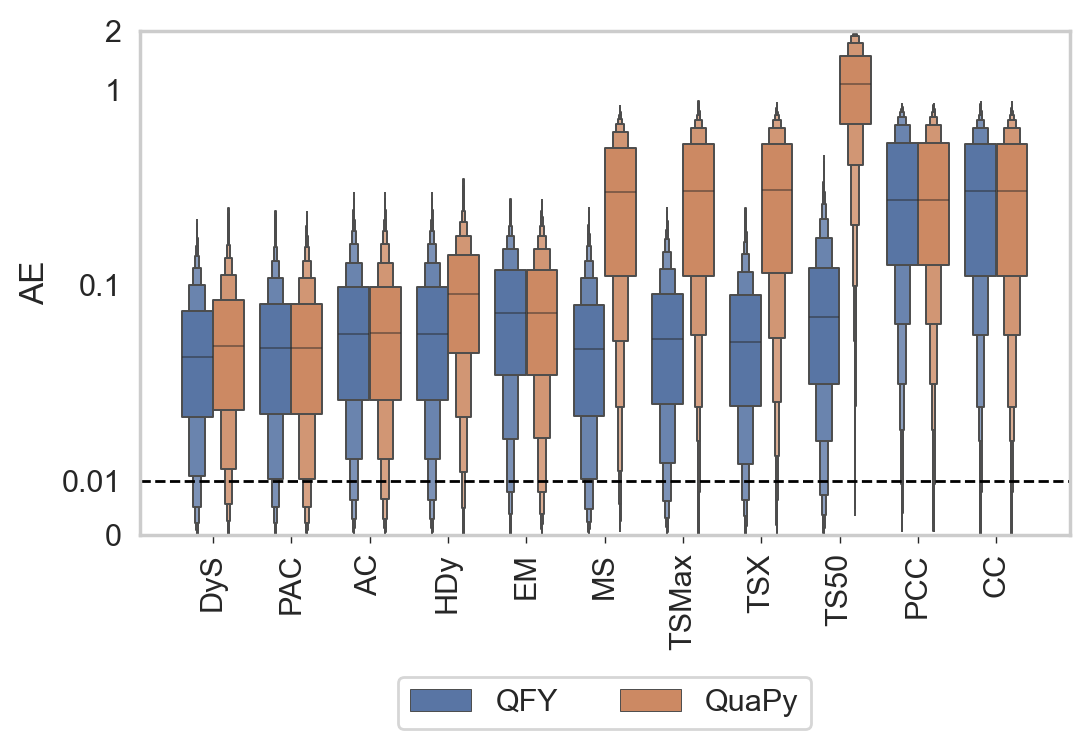

In [11]:
boxenplot_quapy("binary",
                measure="AE",
                ylim=(0,2),
                linthresh=0.01, 
                linscale=0.25, 
                yticks = [0,0.01,0.1,1,2], 
                ylabels=None,
                fname=None)

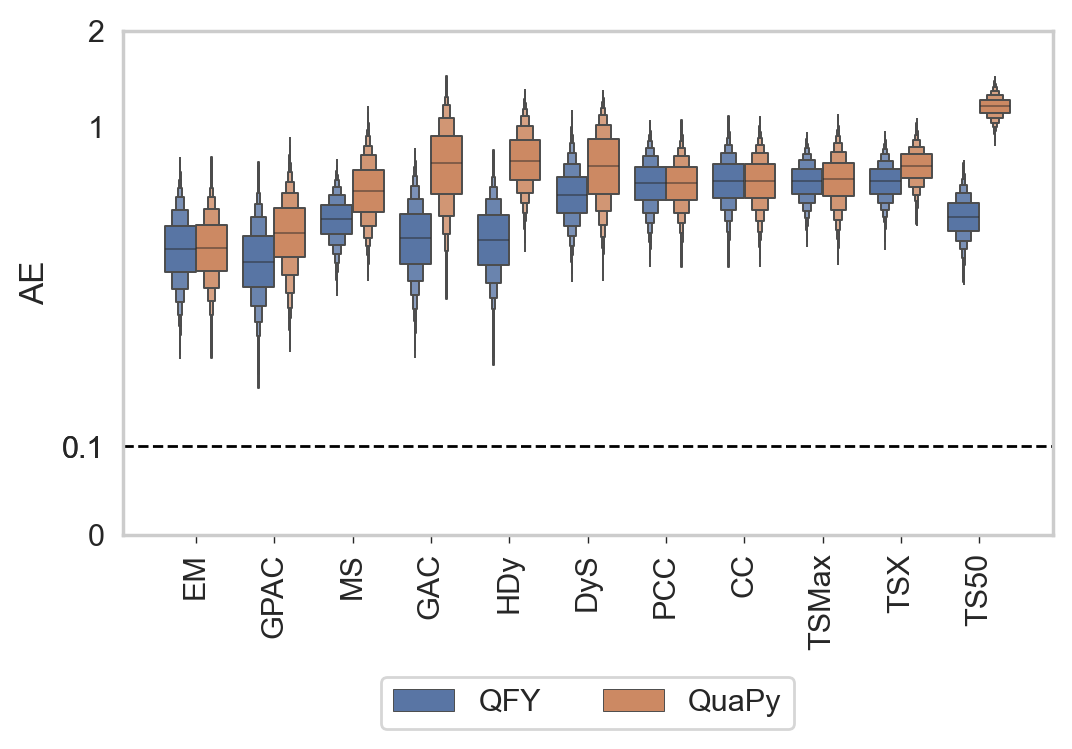

In [12]:
boxenplot_quapy("multiclass",
                measure="AE",
                ylim=(0,2),
                linthresh=0.1, 
                linscale=0.25, 
                yticks = [0,0.1,0.1,1,2], 
                ylabels=None,
                fname=None)